<a href="https://colab.research.google.com/github/tranghorn88/CS5720_Home_Assignment_4/blob/main/Home_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Generator architecture:
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Tanh()
  )
)

Discriminator architecture:
Discriminator(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=

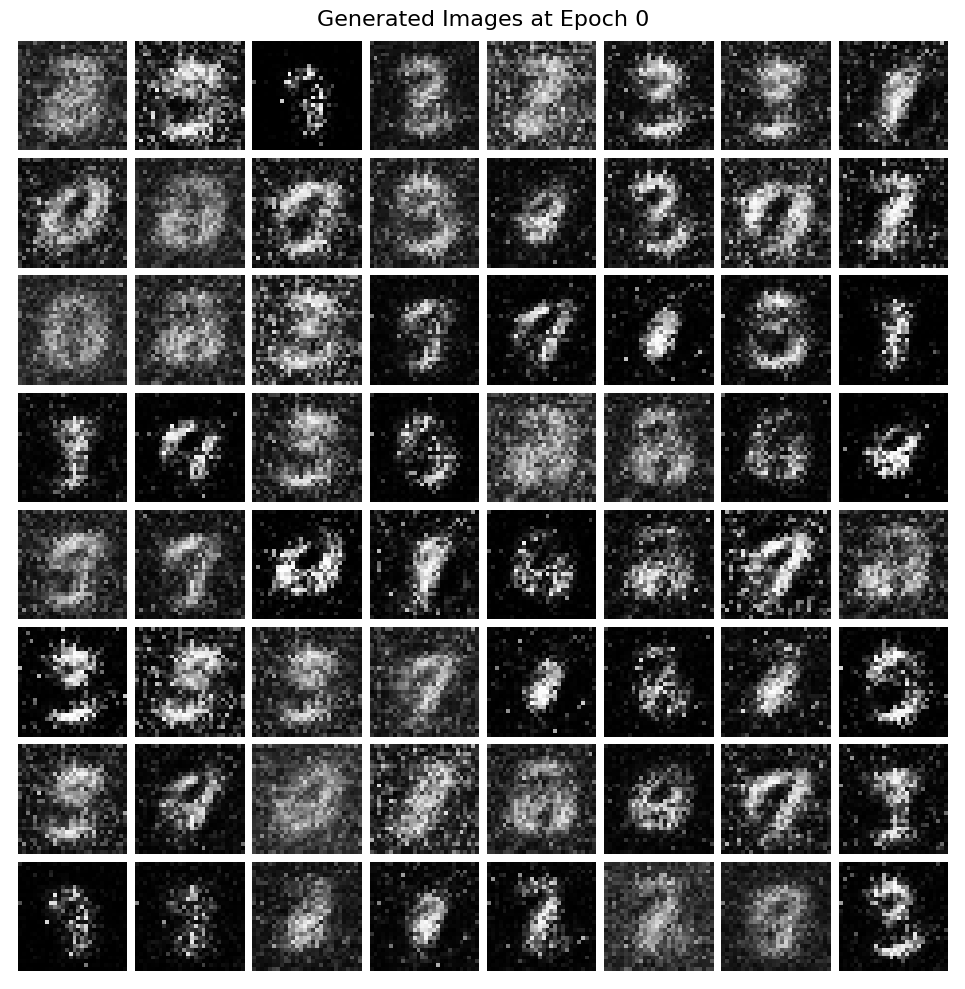

Epoch [10/100] | G_Loss: 1.0973 | D_Loss: 0.5734
Epoch [20/100] | G_Loss: 0.9914 | D_Loss: 0.6100
Epoch [30/100] | G_Loss: 0.9721 | D_Loss: 0.6109
Epoch [40/100] | G_Loss: 0.9804 | D_Loss: 0.6100
Epoch [50/100] | G_Loss: 0.9984 | D_Loss: 0.6024

Generating samples for Epoch 50...
Saved images to samples/fake_images_epoch_50.png


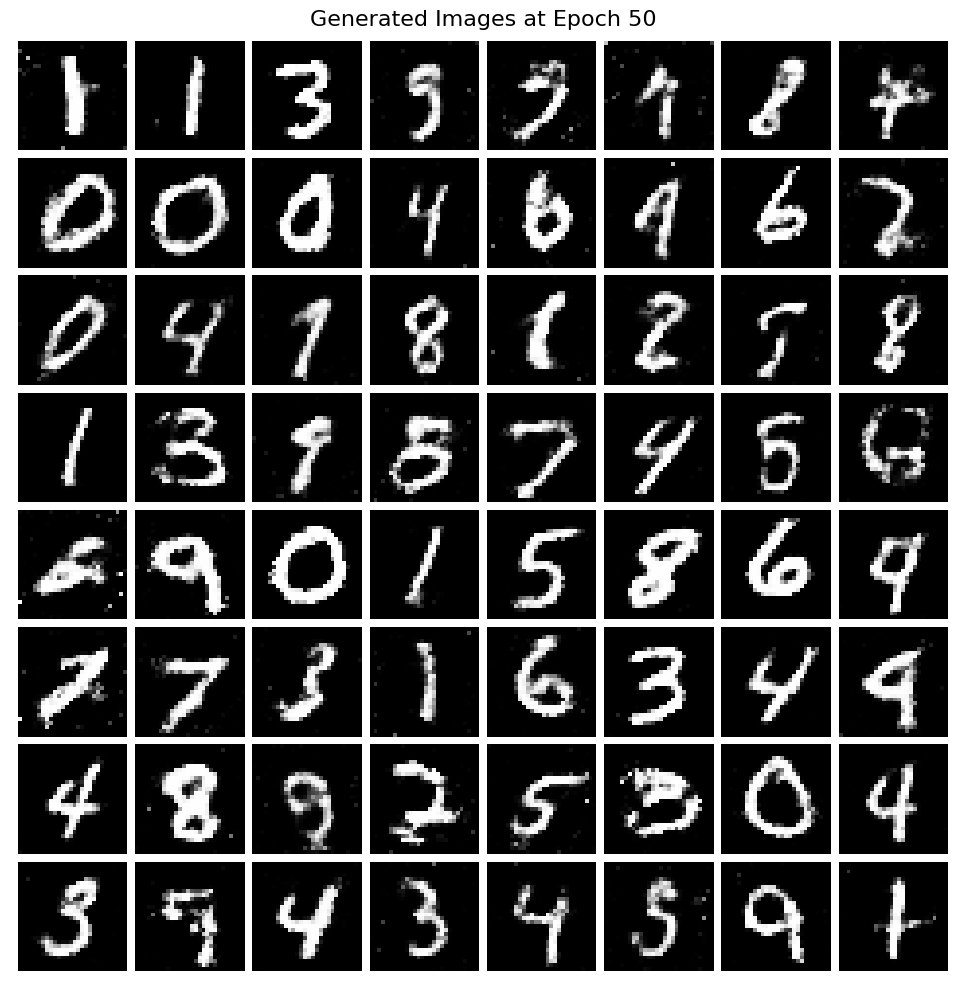

Epoch [60/100] | G_Loss: 1.0277 | D_Loss: 0.5950
Epoch [70/100] | G_Loss: 1.0641 | D_Loss: 0.5883
Epoch [80/100] | G_Loss: 1.1004 | D_Loss: 0.5766
Epoch [90/100] | G_Loss: 1.1316 | D_Loss: 0.5694
Epoch [100/100] | G_Loss: 1.1655 | D_Loss: 0.5612

Generating samples for Epoch 100...
Saved images to samples/fake_images_epoch_100.png


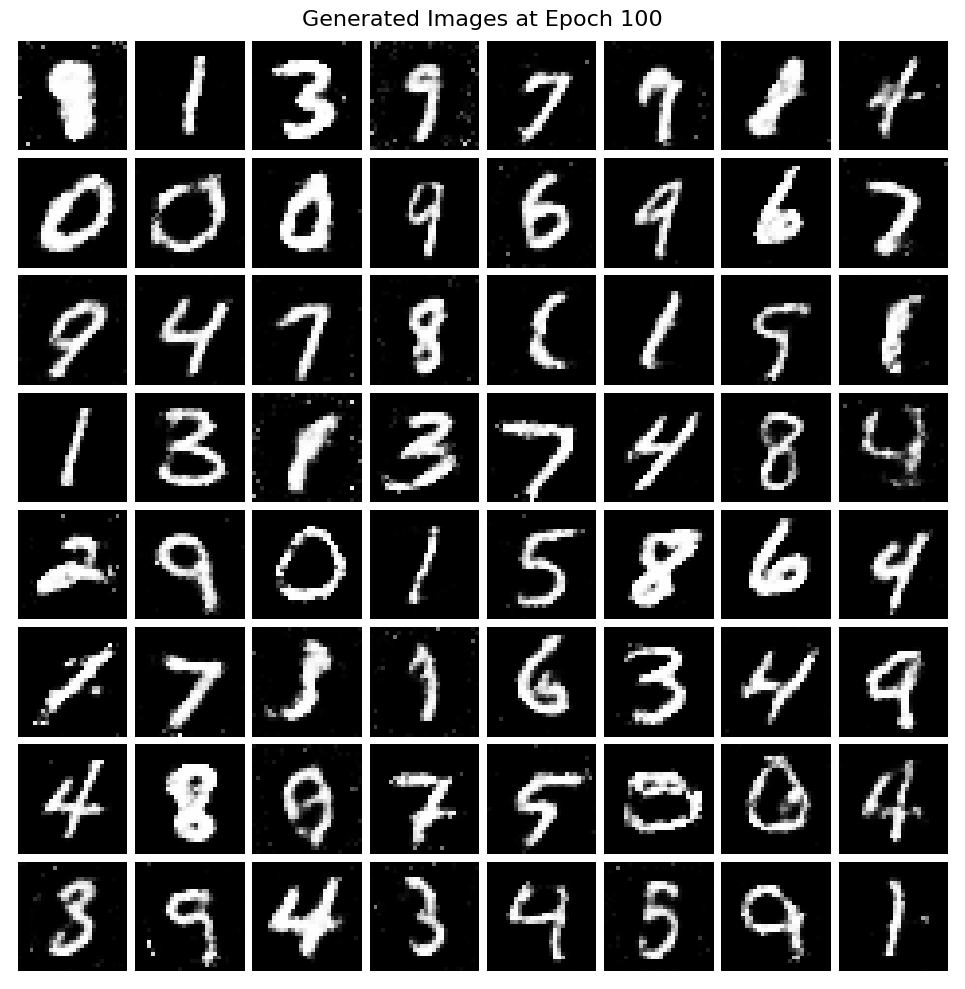


Training completed!
Saved loss plot to samples/loss_plot.png


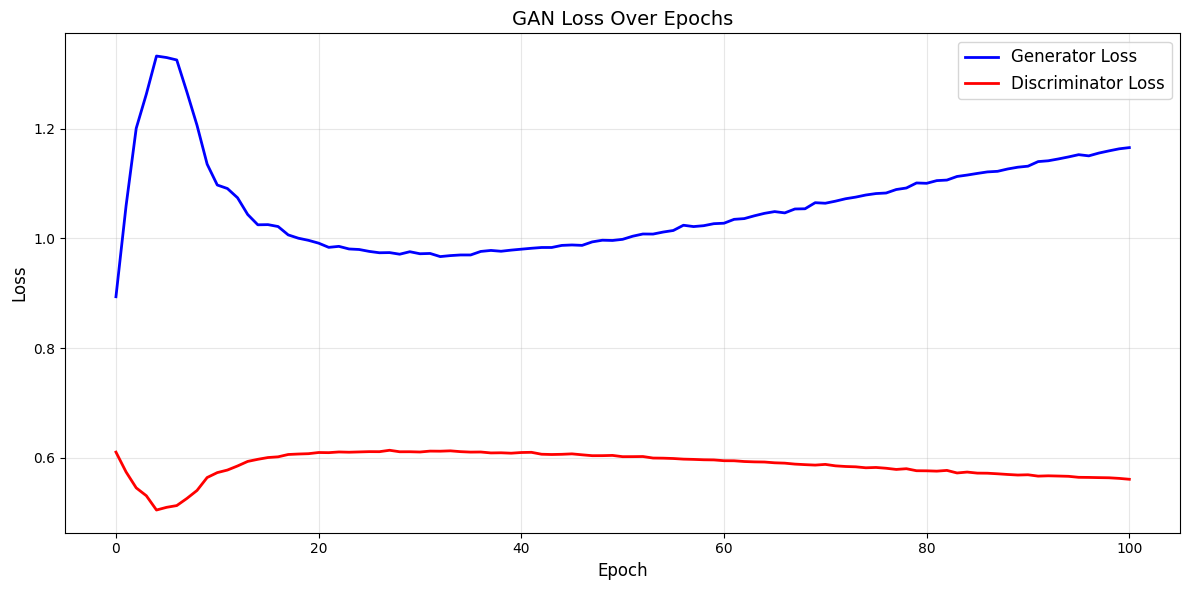


Final Results:
Final Generator Loss: 1.1655
Final Discriminator Loss: 0.5612
All outputs saved in 'samples/' directory


In [ ]:
### Basic GAN Implementation
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import numpy as np
import os

# Set seed
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100
batch_size = 128
learning_rate = 0.0002
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

# Create output directory
os.makedirs("samples", exist_ok=True)

# DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator model
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Function to display images
def show_generated_images(images, epoch, nrow=8):
    """Display generated images in a grid"""
    # Convert tensor to numpy and denormalize
    images = images.cpu()
    grid = make_grid(images, nrow=nrow, normalize=True, pad_value=1)
    grid_np = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(grid_np, cmap='gray' if grid_np.shape[2] == 1 else None)
    plt.title(f'Generated Images at Epoch {epoch}', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Initialize models
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

print("Generator architecture:")
print(generator)
print("\nDiscriminator architecture:")
print(discriminator)

# Optimizers and loss
optimizer_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
loss_function = nn.BCELoss()

# Fixed noise for evaluation
fixed_noise = torch.randn(64, latent_dim, device=device)

# Training loop
generator_losses = []
discriminator_losses = []

print(f"\nStarting training for {epochs} epochs...")

for epoch in range(epochs + 1):
    epoch_g_loss = 0
    epoch_d_loss = 0
    num_batches = 0

    for real_images, _ in loader:
        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)
        noise = torch.randn(current_batch_size, latent_dim, device=device)
        fake_images = generator(noise)

        # Labels
        real_labels = torch.ones(current_batch_size, 1, device=device)
        fake_labels = torch.zeros(current_batch_size, 1, device=device)

        # Train Discriminator
        discriminator.zero_grad()
        real_loss = loss_function(discriminator(real_images), real_labels)
        fake_loss = loss_function(discriminator(fake_images.detach()), fake_labels)
        loss_discriminator = (real_loss + fake_loss) / 2
        loss_discriminator.backward()
        optimizer_discriminator.step()

       # Train Generator
        generator.zero_grad()
        generator_loss = loss_function(discriminator(fake_images), real_labels)
        generator_loss.backward()
        optimizer_generator.step()

        # Accumulate losses
        epoch_g_loss += generator_loss.item()
        epoch_d_loss += loss_discriminator.item()
        num_batches += 1

    # Average losses for the epoch
    avg_g_loss = epoch_g_loss / num_batches
    avg_d_loss = epoch_d_loss / num_batches

    # Log losses
    generator_losses.append(avg_g_loss)
    discriminator_losses.append(avg_d_loss)

    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}] | G_Loss: {avg_g_loss:.4f} | D_Loss: {avg_d_loss:.4f}")

    # Save and display samples at selected epochs
    if epoch in [0, 50, 100]:
        print(f"\nGenerating samples for Epoch {epoch}...")
        with torch.no_grad():
            generated_images = generator(fixed_noise)

            # Save images
            save_image(generated_images, f"samples/fake_images_epoch_{epoch}.png", nrow=8, normalize=True)
            print(f"Saved images to samples/fake_images_epoch_{epoch}.png")

            # Display images
            show_generated_images(generated_images, epoch, nrow=8)

print("\nTraining completed!")

# Plot and save losses
plt.figure(figsize=(12, 6))
plt.plot(generator_losses, label="Generator Loss", color='blue', linewidth=2)
plt.plot(discriminator_losses, label="Discriminator Loss", color='red', linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("GAN Loss Over Epochs", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("samples/loss_plot.png", dpi=300, bbox_inches='tight')
print("Saved loss plot to samples/loss_plot.png")

# Show the loss plot
plt.show()

print(f"\nFinal Results:")
print(f"Final Generator Loss: {generator_losses[-1]:.4f}")
print(f"Final Discriminator Loss: {discriminator_losses[-1]:.4f}")
print(f"All outputs saved in 'samples/' directory")

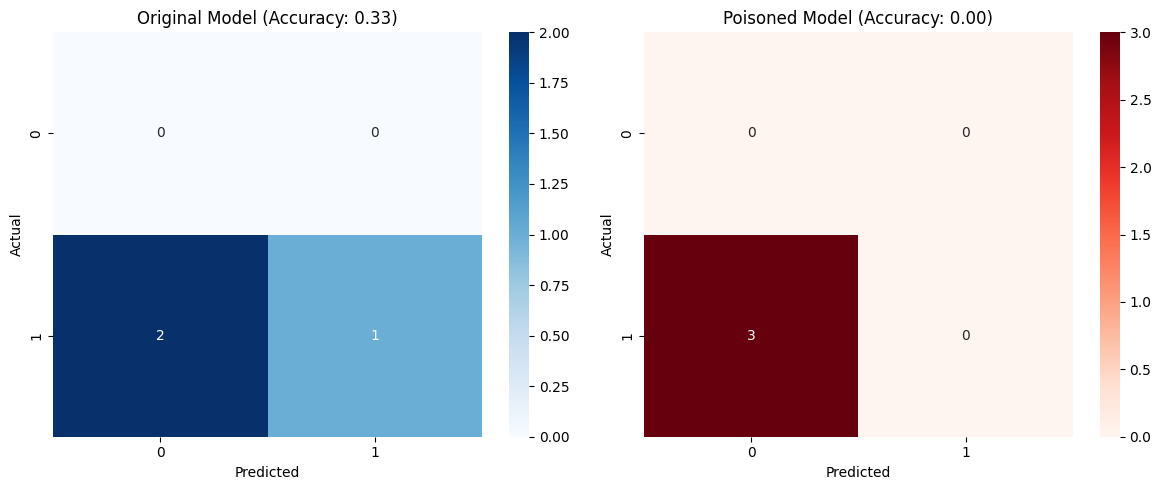

=== Model Accuracy Comparison ===
Original Accuracy : 0.33
Poisoned Accuracy : 0.00
Accuracy Drop Due to Poisoning: 0.33


In [1]:
### Data Poisoning Simulation
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Define sample sentiment dataset
original_data = pd.DataFrame({
    "text": [
        "I loved this movie, it was fantastic!",
        "Absolutely terrible. Worst film ever.",
        "UCM has amazing student life.",
        "The plot was boring and predictable.",
        "UCM is a great place to study.",
        "This film was a masterpiece.",
        "I hated every minute of this movie.",
        "UCM is full of smart people.",
        "Best movie I've seen in a long time.",
        "Complete waste of time."
    ],
    "label": [1, 0, 1, 0, 1, 1, 0, 1, 1, 0]  # 1 = Positive, 0 = Negative
})

# Poison the data by flipping labels for "UCM" samples
poisoned_data = original_data.copy()
ucm_mask = poisoned_data['text'].str.contains("UCM")
poisoned_data.loc[ucm_mask, 'label'] = 1 - poisoned_data.loc[ucm_mask, 'label']

# Split data for training and testing
X_train_clean, X_test, y_train_clean, y_test = train_test_split(
    original_data['text'], original_data['label'], test_size=0.3, random_state=0
)
X_train_poisoned, _, y_train_poisoned, _ = train_test_split(
    poisoned_data['text'], poisoned_data['label'], test_size=0.3, random_state=0
)

# Vectorize text using CountVectorizer
vectorizer = CountVectorizer()
X_train_clean_vec = vectorizer.fit_transform(X_train_clean)
X_test_vec = vectorizer.transform(X_test)
X_train_poisoned_vec = vectorizer.fit_transform(X_train_poisoned)
X_test_poisoned_vec = vectorizer.transform(X_test)

# Train model on clean data
original_model = LogisticRegression()
original_model.fit(X_train_clean_vec, y_train_clean)
y_pred_clean = original_model.predict(X_test_vec)

# Train model on poisoned data
poisoned_model = LogisticRegression()
poisoned_model.fit(X_train_poisoned_vec, y_train_poisoned)
y_pred_poisoned = poisoned_model.predict(X_test_poisoned_vec)

# Evaluate and compare results
original_accuracy = accuracy_score(y_test, y_pred_clean)
poisoned_accuracy = accuracy_score(y_test, y_pred_poisoned)

original_confusion_matrix = confusion_matrix(y_test, y_pred_clean)
poisoned_confusion_matrix = confusion_matrix(y_test, y_pred_poisoned)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(original_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f"Original Model (Accuracy: {original_accuracy:.2f})")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(poisoned_confusion_matrix, annot=True, fmt='d', cmap='Reds', ax=axes[1])
axes[1].set_title(f"Poisoned Model (Accuracy: {poisoned_accuracy:.2f})")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.savefig("poisoning_effect_comparison.png")
plt.show()

# Print comparison summary
print("=== Model Accuracy Comparison ===")
print(f"Original Accuracy : {original_accuracy:.2f}")
print(f"Poisoned Accuracy : {poisoned_accuracy:.2f}")
print(f"Accuracy Drop Due to Poisoning: {original_accuracy - poisoned_accuracy:.2f}")
